## Initial Package Import and Simple Module definition

Modified from ZFTurbo

In [1]:
%matplotlib inline


import shutil

import datetime
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from scipy.io import loadmat
from operator import itemgetter
import random
import os
import time
import glob
import re
from multiprocessing import Process
import copy

#Importing old and new Kfold
from sklearn.cross_validation import KFold
from sklearn.model_selection import KFold as NewKF
from sklearn.model_selection import StratifiedKFold as StratKF

#Importing GroupKfold, only available since version 0.18
from sklearn.model_selection import GroupKFold


#Importing function for scaling data before PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale

#Importing PCA packages
from sklearn.decomposition import PCA, KernelPCA

#Importing FFT package
from scipy.fftpack import fft

#Importing crossvalidation metrics and Gridsearch
from sklearn import cross_validation, metrics
from sklearn.model_selection import GridSearchCV

#Importing wrapper to use XGB with Gridsearch

from xgboost.sklearn import XGBClassifier

#Importing plotting packages (optional)

import matplotlib.pylab as plt

from pandas.tools.plotting import scatter_matrix

from sklearn.model_selection import LeavePGroupsOut
from sklearn.model_selection import GroupShuffleSplit

#Oversampling

from imblearn.over_sampling import SMOTE

from collections import Counter

from imblearn.combine import SMOTETomek



#Defining general modules used in the classification

random.seed(2016)
np.random.seed(2016)


def natural_key(string_):
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]


def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()


def get_importance(gbm, features):
    create_feature_map(features)
    importance = gbm.get_fscore(fmap='xgb.fmap')
    importance = sorted(importance.items(), key=itemgetter(1), reverse=True)
    return importance


def intersect(a, b):
    return list(set(a) & set(b))


def print_features_importance(imp):
    for i in range(len(imp)):
        print("# " + str(imp[i][1]))
        print('output.remove(\'' + imp[i][0] + '\')')


def mat_to_pandas(path):
    mat = loadmat(path)
    names = mat['dataStruct'].dtype.names
    ndata = {n: mat['dataStruct'][n][0, 0] for n in names}
    samp_freq = ndata['iEEGsamplingRate'][0, 0]
    sequence = -1
    if 'sequence' in names:
        sequence = mat['dataStruct']['sequence']
    return pd.DataFrame(ndata['data'], columns=ndata['channelIndices'][0]), sequence, samp_freq

def create_submission(score, test, prediction, feature_model, short_size, new_test):
    # Make Submission
    now = datetime.datetime.now()
    sub_file = 'submission_' + str(score) + '_' + 'model_'+str(feature_model)+'_short_'+str(short_size)+'_new_test_'+str(new_test)+'_'+ str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
    print('Writing submission: ', sub_file)
    f = open(sub_file, 'w')
    f.write('File,Class\n')
    total = 0
    for id in test['Id']:
        patient = id // 100000
        fid = id % 100000
        str1 = 'new_' + str(patient) + '_' + str(fid) + '.mat' + ',' + str(prediction[total])
        str1 += '\n'
        total += 1
        f.write(str1)
    f.close()


def get_features(train, test):
    trainval = list(train.columns.values)
    testval = list(test.columns.values)
    output = intersect(trainval, testval)
    output.remove('Id')
    # output.remove('file_size')
    return sorted(output)

    


/home/rodolfoxps/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Module for Creating Features and Saving to CSV Files

#### One file per patient per test/training

In [2]:
#Modules to read train and test data.
#Short_dataset can be False or TRue. It decides whether to use the lon or short sample size.

def create_simple_csv_train(patient_id, feature_model, num_features, short_dataset=False, new_test=False):
    
    feature_file='_'+str(feature_model)+'_short_'+str(short_dataset)+'_new_test_'+ str(new_test)
    
    if short_dataset:
        
        source_dir="./data/train_"
    else:
        source_dir="./train_"
    
    new_label=''
    if new_test:
        
        new_label='_new'

    out = open("simple_train_" + str(patient_id) + feature_file + ".csv", "w")
    out.write("Id,sequence_id,patient_id,")
  
    columns=''
    for i in range(16):
        for j in range(num_features):
            columns+= 'ch_'+str(i)+'_'+"band_"+str(j)+","        

    out.write(columns+"file_size,result\n")

    # TRAIN (0)
    out_str = ''
    files = sorted(glob.glob(source_dir + str(patient_id) + "/*.mat"), key=natural_key)
    print ('train files'+ str(patient_id), len(files))    
    pos1=0
    neg1=0
    sequence_id_pre = int(patient_id)*1000
    sequence_id_inter = int(patient_id)*1000
    total_pre = 0
    total_inter=0
    seq1=0
    
    new_train = pd.read_csv('train_and_test_data_labels_safe'+'.csv')
    new_data = new_train['image']
    
    selection = new_train[new_train['safe'] == 1].drop('safe', axis=1)
    
    for fl in files:
        
        # print('Go for ' + fl)
               
        if os.path.basename(fl) not in selection['image'].values:
            continue
        
        id_str = os.path.basename(fl)[:-4]
        arr = id_str.split("_")
        patient = int(arr[0])
        id = int(arr[1])
        result = int(arr[2])
        
        if result == 1:
            
            total_pre += 1
            sequence_id=int(patient_id)*1000+int((total_pre-1) // 6) + int((total_inter-1) // 6) + 1

            
        elif result == 0:
            
            total_inter += 1            
            sequence_id=int(patient_id)*1000+int((total_pre) // 6) + int((total_inter-1) // 6)

        
        new_id = int(patient*100000 + id)
        try:
            tables, sequence_from_mat, samp_freq = mat_to_pandas(fl)
        except:
            print('Some error here {}...'.format(fl))
            continue
        print(sequence_id)
        out_str += str(new_id) + "," + str(sequence_id) + "," + str(patient)

        sizesignal=int(tables.shape[0])       
        
        for f in sorted(list(tables.columns.values)):
            
            out_str=feature_eng(tables[f], out_str,feature_model, sizesignal, samp_freq)
            
            
        out_str += "," + str(os.path.getsize(fl)) + "," + str(result) + "\n"
        #print(sequence_from_mat)
        #print(type(sequence_from_mat))
        seq1=int(sequence_from_mat[0][0][0][0])
        print('total preictal: ', total_pre,' total interictal: ', total_inter,' sequence local: ', seq1)
        if (total_pre % 6 == 0) and result == 1:
                pos1 += 1
                print('Positive ocurrence sequence finished', pos1)
                if (seq1==6):
                    sequence_id_pre += 1
                    print ('sequence preictal next',sequence_id_pre)
        
        if (total_inter % 6 == 0) and result == 0:                
                neg1 += 1
                print('Negative ocurrence sequence finished', neg1)
                if (seq1==6):
                    sequence_id_inter += 1
                    print ('sequence interictal next',sequence_id_inter)

    out.write(out_str)
    
    out.close()
    print('Train CSV for patient {} has been completed...'.format(patient_id))


def create_simple_csv_test(patient_id, feature_model, num_features, short_dataset=False, new_test=False):
    
    feature_file='_'+str(feature_model)+'_short_'+str(short_dataset)+'_new_test_'+str(new_test)
    
    if short_dataset:
        
        source_dir="./data/test_"
    else:
        source_dir="./test_"
    
    new_label=''
    
    if new_test:
        
        new_label="_new"

    # TEST
    out_str = ''
    files = sorted(glob.glob(source_dir + str(patient_id) + new_label + "/*.mat"), key=natural_key)
    print ('test files'+ str(patient_id), len(files))    
    out = open("simple_test_" + str(patient_id) + feature_file + ".csv", "w")
    out.write("Id,patient_id,")
    
    columns=''
    for i in range(16):
        for j in range(num_features):
            columns+= 'ch_'+str(i)+'_'+"band_"+str(j)+","        
    
    out.write(columns+"file_size\n")
    
        
    for fl in files:
        # print('Go for ' + fl)
        id_str = os.path.basename(fl)[4:-4]
        arr = id_str.split("_")
        patient = int(arr[0])
        id = int(arr[1])
        new_id = int(patient*100000 + id)
        try:
            tables, sequence_from_mat, samp_freq = mat_to_pandas(fl)
        except:
            print('Some error here {}...'.format(fl))
            continue
        out_str += str(new_id) + "," + str(patient)

        sizesignal=int(tables.shape[0])           
        
        
        
        
        for f in sorted(list(tables.columns.values)):
            
            out_str=feature_eng(tables[f], out_str,feature_model, sizesignal, samp_freq)
                        
        out_str += "," + str(os.path.getsize(fl)) + "\n"
        # break

    out.write(out_str)
    out.close()
    print('Test CSV for patient {} has been completed...'.format(patient_id))


In [38]:

def create_subset_train(feature_model):
    
   
    
#    filestotal = sorted(glob.glob(source_dir + str(patient_id) + "/*.mat"), key=natural_key)

    
    folder_list=['train_1','train_2','train_3']
    
    
    
    for folder_label in folder_list:
        
        short_size=False
        
        patient_id=int(list(filter(str.isdigit, folder_label))[0])
        
        new_test=True      
        if len(folder_label)>7:
  
            var=6
            
        else:
            var=7
        
        files = pd.read_csv('simple_'+ folder_label[0:var]+'_'+str(feature_model)+'_short_'+str(short_size)+'_new_test_'+str(new_test)+'.csv')

        files_index=pd.Series(files['sequence_id'], index=files['sequence_id'].index)

        
        files_unique =files.drop_duplicates(subset=['sequence_id'])
        
#       print(files_unique)
        

        files_1=files_unique[files_unique['result'] == 1]['sequence_id']
        files_0=files_unique[files_unique['result'] == 0]['sequence_id']
        
        print(files_1.shape)
        print(files_0.shape)
    
        n_samples_1=int(len(files_1)/10)
        n_samples_0=int(len(files_0)/10)
        

    
        files_1_rand=np.random.choice(files_1, size=n_samples_1)
        files_0_rand=np.random.choice(files_0, size=n_samples_0)
        
        
        files_1_rand_seq=files[files_index.isin(files_1_rand)]['Id']
        files_0_rand_seq=files[files_index.isin(files_0_rand)]['Id']
        
        for file in files_1_rand_seq:
        
            id_file=str(file % 1000)
            source_file='./'+folder_label+'/'+str(patient_id)+'_'+id_file+'_1.mat'
            target_file='./data_random/' + folder_label+'/'+str(patient_id)+'_'+id_file+'_1.mat'
            print(target_file)
    
            shutil.copyfile(source_file, target_file) 

        for file in files_0_rand_seq:
        
            id_file=str(file % 1000)
            source_file='./'+folder_label+'/'+str(patient_id)+'_'+id_file+'_0.mat'
            target_file='./data_random/' + folder_label+'/'+str(patient_id)+'_'+id_file+'_0.mat'
            print(target_file)
    
            shutil.copyfile(source_file, target_file)   
    

In [40]:
feature_model=3
short_size=False
num_features=12
new_test=True


create_subset_train(feature_model)

(25,)
(95,)
./data_random/train_1/1_31_1.mat
./data_random/train_1/1_32_1.mat
./data_random/train_1/1_33_1.mat
./data_random/train_1/1_34_1.mat
./data_random/train_1/1_35_1.mat
./data_random/train_1/1_36_1.mat
./data_random/train_1/1_127_1.mat
./data_random/train_1/1_128_1.mat
./data_random/train_1/1_129_1.mat
./data_random/train_1/1_130_1.mat
./data_random/train_1/1_131_1.mat
./data_random/train_1/1_132_1.mat
./data_random/train_1/1_85_0.mat
./data_random/train_1/1_86_0.mat
./data_random/train_1/1_87_0.mat
./data_random/train_1/1_88_0.mat
./data_random/train_1/1_89_0.mat
./data_random/train_1/1_90_0.mat
./data_random/train_1/1_235_0.mat
./data_random/train_1/1_236_0.mat
./data_random/train_1/1_237_0.mat
./data_random/train_1/1_238_0.mat
./data_random/train_1/1_239_0.mat
./data_random/train_1/1_240_0.mat
./data_random/train_1/1_649_0.mat
./data_random/train_1/1_650_0.mat
./data_random/train_1/1_651_0.mat
./data_random/train_1/1_652_0.mat
./data_random/train_1/1_653_0.mat
./data_random/

In [26]:


def create_subset_test(feature_model):
    
   
    
#    filestotal = sorted(glob.glob(source_dir + str(patient_id) + "/*.mat"), key=natural_key)

    
    folder_list=['test_1_new','test_2_new','test_3_new']
    
    
    
    for folder_label in folder_list:
        
        short_size=False
        
        patient_id=int(list(filter(str.isdigit, folder_label))[0])
        
        new_test=True      
        if len(folder_label)>7:
  
            var=6
            
        else:
            var=7
        
        files = pd.read_csv('simple_'+ folder_label[0:var]+'_'+str(feature_model)+'_short_'+str(short_size)+'_new_test_'+str(new_test)+'.csv')

             

        files_total=files['Id']

    
        n_samples=int(len(files_total)/10)

    
        files_rand=np.random.choice(files_total, size=n_samples)

             
        
        for file in files_rand:
        
            id_file=str(file % 1000)
            source_file='./'+folder_label+'/new_'+str(patient_id)+'_'+id_file+'.mat'
            target_file='./data_random/' + folder_label+'/new_'+str(patient_id)+'_'+id_file+'.mat'
            print(target_file)
    
            shutil.copyfile(source_file, target_file) 


In [27]:
feature_model=3
short_size=False
num_features=12
new_test=True


create_subset_test(feature_model)

./data_random/test_1_new/new_1_60.mat
./data_random/test_1_new/new_1_122.mat
./data_random/test_1_new/new_1_76.mat
./data_random/test_1_new/new_1_67.mat
./data_random/test_1_new/new_1_3.mat
./data_random/test_1_new/new_1_167.mat
./data_random/test_1_new/new_1_153.mat
./data_random/test_1_new/new_1_139.mat
./data_random/test_1_new/new_1_178.mat
./data_random/test_1_new/new_1_105.mat
./data_random/test_1_new/new_1_134.mat
./data_random/test_1_new/new_1_158.mat
./data_random/test_1_new/new_1_151.mat
./data_random/test_1_new/new_1_193.mat
./data_random/test_1_new/new_1_127.mat
./data_random/test_1_new/new_1_15.mat
./data_random/test_1_new/new_1_215.mat
./data_random/test_1_new/new_1_34.mat
./data_random/test_1_new/new_1_127.mat
./data_random/test_1_new/new_1_75.mat
./data_random/test_1_new/new_1_69.mat
./data_random/test_2_new/new_2_298.mat
./data_random/test_2_new/new_2_656.mat
./data_random/test_2_new/new_2_318.mat
./data_random/test_2_new/new_2_431.mat
./data_random/test_2_new/new_2_812

## Feature Engineering

In [32]:
#eng_number is the feature_value that has values 0,1,2,3... infinite, given by the list below.

def feature_eng(data_sensor, out_str, eng_number, sizesignal, fs):

                
    yf1 = fft(data_sensor)
    fftpeak=2/sizesignal * np.abs(yf1[0:sizesignal/2])
 
    numberofbands=4

    sizeband=20/numberofbands

    if eng_number==3:
        
    
        ###Band Frequency filtering###
        from scipy.signal import butter, lfilter

        ##Frequency parameters##
        #Start frequency#+
        fini = 4
        #End frequency#
        fend = 30
        #Frequency band range#
        frng = 4
        #Frequency overlap#
        fovr = 2
    
        #Frequency band generator#
        fbands = [[f, f + frng] for f in range(fini, fend - (frng - fovr), frng - fovr)]
    
        #Filter order#
        order = 5
        #Nyquist frequency#
        fnyq = fs / 2.0
        

        for fb in fbands:
        
            #Create butterworth bandpass filter#
            b, a = butter(order, fb  / fnyq, btype='band')
            
            #Apply filter#
            data_filter = lfilter(b, a, data_sensor)
            
            #Band pass 'power'#
            band_pwr = np.square(data_filter)
            
            avg_band_pwr = band_pwr.mean()
            
            out_str += "," + str(avg_band_pwr)
            

    elif eng_number==2:
        
        mean = data_sensor.mean()
        
        peak1=fftpeak[0:3].mean()            
        peak2=fftpeak[3:6].mean()          
        peak3=fftpeak[6:9].mean()
        peak4=fftpeak[9:12].mean()
        peak5=fftpeak[12:15].mean()            
        peak6=fftpeak[15:18].mean()          
        peak7=fftpeak[18:21].mean()
        peak8=fftpeak[21:24].mean()
        peak9=fftpeak[24:27].mean()            
        peak10=fftpeak[27:30].mean()          
        peak11=fftpeak[30:33].mean()
        peak12=fftpeak[33:36].mean()
            
        out_str += "," + str(mean)+ "," + str(peak1) + "," + str(peak2) + "," + str(peak3) +"," + str(peak4) \
                    +"," + str(peak5) + "," + str(peak6) + "," + str(peak7) +"," + str(peak8)+ "," + str(peak9) \
                    +"," + str(peak10) + "," + str(peak11) +"," + str(peak12)
    
    elif eng_number==1:
            
        mean = data_sensor.mean()   
        
        peak1=fftpeak[0:5].mean()            
        peak2=fftpeak[5:10].mean()          
        peak3=fftpeak[10:15].mean()
        peak4=fftpeak[15:20].mean()
        
        out_str += "," + str(mean)+ "," + str(peak1) + "," + str(peak2) + "," + str(peak3) +"," + str(peak4)
    
    elif eng_number==0:
            
        mean = data_sensor.mean()
    
        out_str += "," + str(mean)
    
    return out_str

## Module for Reading Test and Train Feature Files and Concatenating

In [33]:


def read_test_train(feature_model, short_size=False, new_test=False):
    feature_file='_'+str(feature_model)
    print("Load train.csv...")
    train1 = pd.read_csv('simple_train_1'+feature_file+'_short_'+str(short_size)+'_new_test_'+str(new_test)+'.csv')
    train2 = pd.read_csv('simple_train_2'+feature_file+'_short_'+str(short_size)+'_new_test_'+str(new_test)+'.csv')
    train3 = pd.read_csv('simple_train_3'+feature_file+'_short_'+str(short_size)+'_new_test_'+str(new_test)+'.csv')
    train = pd.concat([train1, train2, train3])
    # Remove all zeroes files
    train = train[train['file_size'] > 55000].copy()
    # Shuffle rows since they are ordered
    train = train.iloc[np.random.permutation(len(train))]
    # Reset broken index
    train = train.reset_index()
    print("Load test.csv...")
    test1 = pd.read_csv('simple_test_1'+feature_file+'_short_'+str(short_size)+'_new_test_'+str(new_test)+'.csv')
    test2 = pd.read_csv('simple_test_2'+feature_file+'_short_'+str(short_size)+'_new_test_'+str(new_test)+'.csv')
    test3 = pd.read_csv('simple_test_3'+feature_file+'_short_'+str(short_size)+'_new_test_'+str(new_test)+'.csv')
    test = pd.concat([test1, test2, test3])
    print("Process tables...")
    features = get_features(train, test)
    return train, test, features
    

 

## Running Creation of Feature Files (!!!)

In [34]:

feature_model=3
short_size=False
num_features=12
new_test=True


if __name__ == '__main__':
    print('XGBoost: {}'.format(xgb.__version__))
    if 1:
        # Do reading and processing of MAT files in parallel
        p = dict()
        p[1] = Process(target=create_simple_csv_train, args=(1,feature_model,num_features,short_size,new_test))
        p[1].start()
        p[2] = Process(target=create_simple_csv_train, args=(2,feature_model,num_features,short_size,new_test))
        p[2].start()
        p[3] = Process(target=create_simple_csv_train, args=(3,feature_model,num_features,short_size,new_test))
        p[3].start()
        p[4] = Process(target=create_simple_csv_test, args=(1,feature_model,num_features,short_size,new_test))
        p[4].start()
        p[5] = Process(target=create_simple_csv_test, args=(2,feature_model,num_features,short_size,new_test))
        p[5].start()
        p[6] = Process(target=create_simple_csv_test, args=(3,feature_model,num_features,short_size,new_test))
        p[6].start()
        p[1].join()
        p[2].join()
        p[3].join()
        p[4].join()
        p[5].join()
        p[6].join()

  

XGBoost: 0.6
test files2 1002
test files1 216
train files1 1302
test files3 690
train files2 2346
train files3 2394
2000


/home/rodolfoxps/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rodolfoxps/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rodolfoxps/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rodolfoxps/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


1000


/home/rodolfoxps/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


3000


/home/rodolfoxps/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


total preictal:  0  total interictal:  1  sequence local:  1
total preictal:  0  total interictal:  1  sequence local:  1
total preictal:  1  total interictal:  0  sequence local:  1
2001
1000
3001
total preictal:  1  total interictal:  1  sequence local:  1
2000
total preictal:  2  total interictal:  0  sequence local:  2
1000
total preictal:  1  total interictal:  1  sequence local:  1
total preictal:  1  total interictal:  2  sequence local:  2
total preictal:  3  total interictal:  0  sequence local:  3
3000
2001
1000
total preictal:  1  total interictal:  2  sequence local:  2
3001
total preictal:  4  total interictal:  0  sequence local:  4
total preictal:  2  total interictal:  2  sequence local:  2
1000
2000
total preictal:  2  total interictal:  2  sequence local:  2
3000
total preictal:  5  total interictal:  0  sequence local:  5
1000
total preictal:  2  total interictal:  3  sequence local:  3
total preictal:  2  total interictal:  3  sequence local:  3
2001
3001
total prei

## Reading Feature Files

In [107]:
feature_model=3
short_size=False
num_features=12
new_test=True

if __name__ == '__main__':
    print('XGBoost: {}'.format(xgb.__version__))
    
    train, test, features = read_test_train(feature_model, short_size, new_test)
    print('Length of train: ', len(train))
    print('Length of test: ', len(test))
    print('Features [{}]: {}'.format(len(features), sorted(features)))
    
#   print ('train',train['sequence_id'])

XGBoost: 0.6
Load train.csv...
Load test.csv...
Process tables...
Length of train:  4698
Length of test:  1908
Features [194]: ['ch_0_band_0', 'ch_0_band_1', 'ch_0_band_10', 'ch_0_band_11', 'ch_0_band_2', 'ch_0_band_3', 'ch_0_band_4', 'ch_0_band_5', 'ch_0_band_6', 'ch_0_band_7', 'ch_0_band_8', 'ch_0_band_9', 'ch_10_band_0', 'ch_10_band_1', 'ch_10_band_10', 'ch_10_band_11', 'ch_10_band_2', 'ch_10_band_3', 'ch_10_band_4', 'ch_10_band_5', 'ch_10_band_6', 'ch_10_band_7', 'ch_10_band_8', 'ch_10_band_9', 'ch_11_band_0', 'ch_11_band_1', 'ch_11_band_10', 'ch_11_band_11', 'ch_11_band_2', 'ch_11_band_3', 'ch_11_band_4', 'ch_11_band_5', 'ch_11_band_6', 'ch_11_band_7', 'ch_11_band_8', 'ch_11_band_9', 'ch_12_band_0', 'ch_12_band_1', 'ch_12_band_10', 'ch_12_band_11', 'ch_12_band_2', 'ch_12_band_3', 'ch_12_band_4', 'ch_12_band_5', 'ch_12_band_6', 'ch_12_band_7', 'ch_12_band_8', 'ch_12_band_9', 'ch_13_band_0', 'ch_13_band_1', 'ch_13_band_10', 'ch_13_band_11', 'ch_13_band_2', 'ch_13_band_3', 'ch_13_ban

## Module for Training and Prediction

In [148]:
def run_train_predict(nfolds, train, test, features, target, random_state=2016, PCAkey=False, PCAgraph=False,
                      PCAkeyGS=False, SEQoriginal=False,
                     Oversampling=False, GridSearch=False):

    num_boost_round = 1000
    early_stopping_rounds = 50
    
    train_index_group=[]
    test_index_group=[]
    
    
    unique_seq = train.drop_duplicates(subset=['sequence_id'])
    unique_seq_y = unique_seq['result'].values
    
    print('unique seq y', len(unique_seq_y) )
    
    n_samples=len(unique_seq_y)
    print('length',n_samples)
    unique_seq_X = np.zeros(n_samples)
    
    print('unique seq X', len(unique_seq_X)  )
    
    
    print('train pre', train.shape) 

    yfull_train = dict()
    yfull_test = copy.deepcopy(test[['Id']].astype(object))

    unique_sequences = np.array(train['sequence_id'].unique())
    print('unique sequences pre', unique_sequences.shape)

    groups1=np.fix(unique_sequences/1000)
    
    groups2=groups1.astype(int)
#    print('groups', groups2)
    

    
    if SEQoriginal:
        sequences_full=np.mod(train['sequence_id'].values,1000)
        print('sequences full', sequences_full.shape)
        unique_sequences2=np.mod(unique_sequences,1000)
        unique_sequences_fold=pd.Series(sequences_full, index=train['sequence_id'].index)
#        print('unique_sequences_fold', unique_sequences_fold)
    
        unique_sequences = np.unique(unique_sequences2)
        print('unique sequences pre', unique_sequences.shape)

    else:
        unique_sequences_fold=pd.Series(train['sequence_id'], index=train['sequence_id'].index)

    gkf = GroupKFold(n_splits=3)
    test1=gkf.split(unique_sequences, groups=groups2)
    test2=gkf.split(unique_sequences, groups=groups2)
    
    #random_state=random_state
    print('unique sequences', unique_sequences.shape)
#    splitKF = KFold(len(unique_sequences), n_folds=nfolds, shuffle=True, random_state=random_state)
#    kf = NewKF(n_splits=nfolds, shuffle=True, random_state=random_state)
    kf = StratKF(n_splits=nfolds, shuffle=True, random_state=random_state)
    
    num_fold = 0
    num_fold1=0
    
    eta = 0.2
    max_depth = 7
    subsample = 0.9
    colsample_bytree = 0.9
    start_time = time.time()

    print('XGBoost params. ETA: {}, MAX_DEPTH: {}, SUBSAMPLE: {}, COLSAMPLE_BY_TREE: {}'.format(eta, max_depth, subsample, colsample_bytree))
    params = {
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "eta": eta,
        "tree_method": 'exact',
        "max_depth": max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent": 1,
        "seed": random_state,
        "gamma": 0,
        "min_child_weight": 3,
        "scale_pos_weight":1,
        "seed":27
    }

    
#   Using best parameters to train model 

    if GridSearch:
    
        splitKF=kf.split(unique_seq_X, unique_seq_y)
    
        best_param=param_search_embedded(nfolds, features, target, splitKF, unique_sequences, 
                                         unique_sequences_fold, train, PCAkeyGS)
    
        print('after best_param', best_param)
    
    for train_seq_index, test_seq_index in kf.split(unique_seq_X, unique_seq_y):
        num_fold += 1
        print('Start fold {} from {}'.format(num_fold, nfolds))
        train_seq = unique_sequences[train_seq_index]
        valid_seq = unique_sequences[test_seq_index]
        print('Length of train people: {}'.format(len(train_seq)))
        print('Length of valid people: {}'.format(len(valid_seq)))
        
#        print('train_seq',train_seq)
#        print('valid_seq',valid_seq)

        X_train, X_valid = train[unique_sequences_fold.isin(train_seq)][features], train[unique_sequences_fold.isin(valid_seq)][features]
        y_train, y_valid = train[unique_sequences_fold.isin(train_seq)][target], train[unique_sequences_fold.isin(valid_seq)][target]
        X_test = test[features]
        
#        print('X_train',X_train)
#        print('y_train',y_train)

        print('Length train:', len(X_train))
        print('Length valid:', len(X_valid))
        
#       Scaling for PCA


        scaler = MinMaxScaler()   
        
        Xtrain_scaled=pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
        Xvalid_scaled=pd.DataFrame(scaler.fit_transform(X_valid), columns=X_valid.columns, index=X_valid.index )

        Xtest_scaled=pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns, index=X_test.index)


        if PCAgraph:
            
            pcatest=KernelPCA(n_components=20)
            pcatest.fit(Xtrain_scaled)
            var1=np.cumsum(np.round(pcatest.explained_variance_ratio_, decimals=4)*100)
            f1 = plt.figure()
            print(var1)
            plt.plot(var1)
            plt.show()

    
        if PCAkey:      
        
#       PCA transformation 
            pcatest=PCA(n_components=20)
            X_train_f=pd.DataFrame(pcatest.fit_transform(Xtrain_scaled), index=Xtrain_scaled.index)
            X_valid_f=pd.DataFrame(pcatest.fit_transform(Xvalid_scaled), index=Xvalid_scaled.index)

            X_test_f=pd.DataFrame(pcatest.fit_transform(Xtest_scaled), index=Xtest_scaled.index)

        else:
            X_train_f=X_train
            X_valid_f=X_valid
            X_test_f=X_test
                
        
        y_train_f=y_train
        y_valid_f=y_valid
    
#       SMOTE oversampling
        
#        print('Original dataset shape {}'.format(Counter(y_train)))
#        print('Original dataset shape {}'.format(Counter(X_train_f)))
#        print(X_train_f)
#        print(y_train)

        if Oversampling:
        
            sm1 = SMOTETomek(random_state=42)
            X_res,y_res = sm1.fit_sample(X_train_f,y_train)
            X_train_f=pd.DataFrame(X_res, columns=X_train_f.columns)
            y_train=pd.Series(y_res)
        
#        print('Resampled dataset shape {}'.format(Counter(y_train)))
#        print(X_train_f)
#        print(y_train)
    
    
        
#       Preparation for XGB training

        dtrain = xgb.DMatrix(X_train_f, y_train)
        dvalid = xgb.DMatrix(X_valid_f, y_valid)

        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]       
        
        gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=500)

        yhat = gbm.predict(xgb.DMatrix(X_valid_f), ntree_limit=gbm.best_iteration+1)

#       Each time store portion of precicted data in train predicted values

        for i in range(len(X_valid_f.index)):
            yfull_train[X_valid_f.index[i]] = yhat[i]
            
        print("Validating...")
        check = gbm.predict(xgb.DMatrix(X_valid_f), ntree_limit=gbm.best_iteration+1)
        score = roc_auc_score(y_valid.tolist(), check)
        print('Check error value: {:.6f}'.format(score))

        print("Predict test set...")
        test_prediction1 = gbm.predict(xgb.DMatrix(X_test_f), ntree_limit=gbm.best_iteration+1)
        yfull_test['kfold_' + str(num_fold)] = test_prediction1
        
              

    print('iteration finished')
    # Copy dict to list
    train_res = []
    
    for i in range(len(train.index)):
        train_res.append(yfull_train[i])

    score = roc_auc_score(train[target], np.array(train_res))
    print('Check error value: {:.6f}'.format(score))

    # Find mean for KFolds on test
    merge = []
    for i in range(1, nfolds+1):
        merge.append('kfold_' + str(i))
    yfull_test['mean'] = yfull_test[merge].mean(axis=1)
    
    print()

    print('Training time: {} minutes'.format(round((time.time() - start_time)/60, 2)))


    
    
    
    total_results=yfull_test['mean'].values
    hist, bins = np.histogram(total_results, bins=50)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.show()
    
    
    total_results_train=np.array(train_res)
    hist, bins = np.histogram(total_results_train, bins=50)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.show()
    
    
    return yfull_test['mean'].values, score
    
    

## Module for Grid Search

In [ ]:
def run_param_search(nfolds, train, test, features, target, random_state=2016,  PCAkey=False, SEQoriginal=False):

    num_boost_round = 1000
    early_stopping_rounds = 50
    
    train_index_group=[]
    test_index_group=[]
    

    
    yfull_train = dict()
    yfull_test = copy.deepcopy(test[['Id']].astype(object))
    print('train sequences',train['sequence_id'])
    
    
    unique_sequences = np.array(train['sequence_id'].unique())
#    print('unique sequences', unique_sequences, len(unique_sequences))
    
    groups1=np.fix(unique_sequences/1000)
    
    groups2=groups1.astype(int)
#    print('groups', groups2)
    
    gkf = GroupKFold(n_splits=3)
    test1=gkf.split(unique_sequences, groups=groups2)
    test2=gkf.split(unique_sequences, groups=groups2)
    
    
    if SEQoriginal:
        sequences_full=np.mod(train['sequence_id'].values,1000)
        unique_sequences2=np.mod(unique_sequences,1000)
        unique_sequences_fold=pd.Series(sequences_full, index=train['sequence_id'].index)
#        print('unique_sequences_fold', unique_sequences_fold)
    
        unique_sequences = np.unique(unique_sequences2)

    else:
        unique_sequences_fold=pd.Series(train['sequence_id'], index=train['sequence_id'].index)

    
    kf = KFold(len(unique_sequences), n_folds=nfolds, shuffle=True, random_state=random_state)
    num_fold = 0
    num_fold1=0
    
    
    
    
#   param_test1 = {'max_depth': [3,5]}
#   param_test1 = {'max_depth': [1,3,5,7,9], 'min_child_weight':[1,3,5,7]}
#   param_test1 = {'gamma':[i/10.0 for i in range(0,7)]}
#   param_test1 = { 'subsample':[i/10.0 for i in range(6,10)],'colsample_bytree':[i/10.0 for i in range(6,10)]}  
#   param_test1 = {'max_depth': [1,3], 'min_child_weight':[6,7,8,9,10]}
    param_test1 = {'scale_pos_weight':[1,2,3,4,5], 'max_delta_step':[0,1,2,3,4,5]}

    for train_seq_index1, test_seq_index1 in kf:
        num_fold1 += 1
        print('this is creation of Kfold iterator')
        print('Start fold {} from {}'.format(num_fold1, nfolds))
    
        train_seq1 = unique_sequences[train_seq_index1]
        valid_seq1 = unique_sequences[test_seq_index1]
        
        print(train_seq1)
        print(valid_seq1)

        train_index = train[unique_sequences_fold.isin(train_seq1)].index.values
        test_index = train[unique_sequences_fold.isin(valid_seq1)].index.values

        print(train_index, type(train_index))
        print(test_index, type(test_index))
       
        train_index_group.append(train_index)
        test_index_group.append(test_index)
        
    
    print('train index group',train_index_group)

    custom_cv = [(train_index_group[i], test_index_group[i]) for i in range(0,3) ]
    
#    custom_cv=GroupShuffleSplit(n_splits=nfolds, test_size=0.5, random_state=0)

#    custom_cv = list(zip(train_index_group, test_index_group))

    print('custom cv', custom_cv)
                   

#    Scaling and PCA

    if PCAkey:

        scaler1 = MinMaxScaler() 
    
        train_features=train[features]
        train_target=train[target]
            
        train_scaled=pd.DataFrame(scaler1.fit_transform(train_features), columns=train_features.columns, index=train_features.index)


        pcatest=KernelPCA(kernel='poly')
        train_features_f=pd.DataFrame(pcatest.fit_transform(train_scaled), index=train_scaled.index)

        dmfeatures=train_features_f
        dmtarget=train_target        

    else:
    
        dmfeatures=train[features]
        dmtarget=train[target]
    
#   GridSearch
    
    classifier1=XGBClassifier( learning_rate =0.2, n_estimators=1000, max_depth=1,
        min_child_weight=3, gamma=0, subsample=0.6, colsample_bytree=0.8,
        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

    gsearch1 = GridSearchCV(estimator = classifier1, param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=custom_cv)
  
    
#    gsearch1.fit(dmfeatures,dmtarget,groups=train['sequence_id'])
    gsearch1.fit(dmfeatures,dmtarget)

    print('best parameters, scores')    
    print(gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_)
    
#    classifier2 = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=500)



In [126]:
def param_search_embedded(n_folds,features, target, kf, unique_sequences, unique_sequences_fold, train, 
                          PCAkey=False):

    num_boost_round = 1000
    early_stopping_rounds = 50
    
    train_index_group=[]
    test_index_group=[]
    
    num_fold1=0
    

    
    
#    param_test1 = {'max_depth': [3,5]}
    param_test1 = {'max_depth': [1,3,5,7,9], 'min_child_weight':[1,3,5,7]}
#   param_test1 = {'gamma':[i/10.0 for i in range(0,7)]}
#   param_test1 = { 'subsample':[i/10.0 for i in range(6,10)],'colsample_bytree':[i/10.0 for i in range(6,10)]}  
#   param_test1 = {'max_depth': [1,3], 'min_child_weight':[6,7,8,9,10]}
#    param_test1 = {'scale_pos_weight':[1,2,3,4,5], 'max_delta_step':[0,1,2,3,4,5]}

    for train_seq_index1, test_seq_index1 in kf:
        num_fold1 += 1
        print('this is creation of Kfold iterator')
        print('Start fold {} from {}'.format(num_fold1, n_folds))
    
        train_seq1 = unique_sequences[train_seq_index1]
        valid_seq1 = unique_sequences[test_seq_index1]
        
#        print(train_seq1)
#        print(valid_seq1)

        train_index = train[unique_sequences_fold.isin(train_seq1)].index.values
        test_index = train[unique_sequences_fold.isin(valid_seq1)].index.values

#        print(train_index, type(train_index))
#        print(test_index, type(test_index))
       
        train_index_group.append(train_index)
        test_index_group.append(test_index)
        
    
#    print('train index group',train_index_group)

    custom_cv = [(train_index_group[i], test_index_group[i]) for i in range(0,n_folds) ]
    
#    custom_cv=GroupShuffleSplit(n_splits=nfolds, test_size=0.5, random_state=0)

#    custom_cv = list(zip(train_index_group, test_index_group))

#    print('custom cv', custom_cv)
                   

#    Scaling and PCA

    if PCAkey:

        scaler1 = MinMaxScaler() 
    
        train_features=train[features]
        train_target=train[target]
            
        train_scaled=pd.DataFrame(scaler1.fit_transform(train_features), columns=train_features.columns, index=train_features.index)


        pcatest=PCA(20)
        train_features_f=pd.DataFrame(pcatest.fit_transform(train_scaled), index=train_scaled.index)

        dmfeatures=train_features_f
        dmtarget=train_target        

    else:
    
        dmfeatures=train[features]
        dmtarget=train[target]
    
#   GridSearch

    print('start grid search')
    
    classifier1=XGBClassifier( learning_rate =0.2, n_estimators=1000, max_depth=3,
        min_child_weight=1, gamma=0, subsample=0.9, colsample_bytree=0.9,
        objective= 'binary:logistic', nthread=4, scale_pos_weight=2, seed=27)

    gsearch1 = GridSearchCV(estimator = classifier1, param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=custom_cv)
  
    
#    gsearch1.fit(dmfeatures,dmtarget,groups=train['sequence_id'])
    gsearch1.fit(dmfeatures,dmtarget)

    print('best parameters, scores')    
    print(gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_)
    
#    classifier2 = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=500)

    return gsearch1.best_params_

## Running Grid Search

In [ ]:
run_param_search(3, train, test, features, 'result', SEQoriginal=True, PCAkey=False)

## Running Training, Prediction and Creating Submission

unique seq y 794
length 794
unique seq X 794
train pre (4698, 198)
unique sequences pre (794,)
unique sequences (794,)
XGBoost params. ETA: 0.2, MAX_DEPTH: 7, SUBSAMPLE: 0.9, COLSAMPLE_BY_TREE: 0.9
Start fold 1 from 4
Length of train people: 595
Length of valid people: 199
Length train: 3521
Length valid: 1177
[0]	train-auc:0.882619	eval-auc:0.656875
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[53]	train-auc:0.999903	eval-auc:0.702162

Validating...
Check error value: 0.702162
Predict test set...
Start fold 2 from 4
Length of train people: 595
Length of valid people: 199
Length train: 3524
Length valid: 1174
[0]	train-auc:0.833756	eval-auc:0.63442
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[117]	train-auc:1	eval-auc:0.799477

Validating...
Che

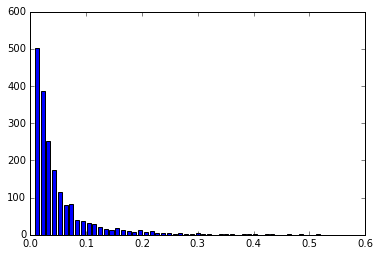

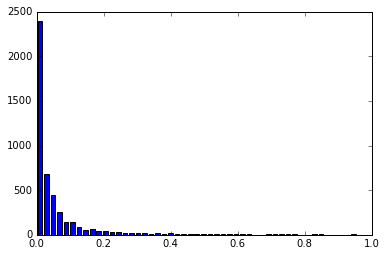

Writing submission:  submission_0.742813048478_model_3_short_False_new_test_True_2016-11-20-14-23.csv


In [149]:
prediction, score = run_train_predict(4, train, test, features, 'result', SEQoriginal=False, PCAkey=False, 
                                      PCAgraph=False, PCAkeyGS=False,
                                      Oversampling=False, GridSearch=False)

create_submission(score, test, prediction, feature_model, short_size, new_test)


In [ ]:
import seaborn as sns

sns.set()


almost_black = '#262626'
palette = sns.color_palette()

f, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(X_vis[y == 0, 0], X_vis[y == 0, 1], label="Class #0", alpha=0.5,
            edgecolor=almost_black, facecolor=palette[0], linewidth=0.15)
ax1.scatter(X_vis[y == 1, 0], X_vis[y == 1, 1], label="Class #1", alpha=0.5,
            edgecolor=almost_black, facecolor=palette[2], linewidth=0.15)
ax1.set_title('Original set')

ax2.scatter(X_res_vis[y_resampled == 0, 0], X_res_vis[y_resampled == 0, 1],
            label="Class #0", alpha=.5, edgecolor=almost_black,
            facecolor=palette[0], linewidth=0.15)
ax2.scatter(X_res_vis[y_resampled == 1, 0], X_res_vis[y_resampled == 1, 1],
            label="Class #1", alpha=.5, edgecolor=almost_black,
            facecolor=palette[2], linewidth=0.15)
ax2.set_title('SMOTE svm')



plt.show()

In [ ]:
y=train['result'].values
y_resampled=y
        
#       PCA transformation 
pcatest=PCA(n_components=4)
X_test=pcatest.fit_transform(train[features])
X_vis=X_test[:,0:2]
X_res_vis=X_test[:,2:4]

print(X_vis.shape,X_res_vis.shape, X_test.shape)